In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob as gb
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import sklearn
import imghdr

In [4]:
train_dir = 'data/train' 
test_dir = 'data/test' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, image_class)):
        image_path = os.path.join(train_dir, image_class, image)
        
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in image_exts:
                print('Image not in the extension list: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}: {}'.format(image_path, e))
            os.remove(image_path)

In [6]:
for image_class in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, image_class)):
        image_path = os.path.join(test_dir, image_class, image)
        
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in image_exts:
                print('Image not in the extension list: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}: {}'.format(image_path, e))
            os.remove(image_path)

In [7]:
dataset = tf.keras.utils.image_dataset_from_directory(train_dir)

Found 28709 files belonging to 7 classes.


In [8]:
path = train_dir
size = []

for folder in os.listdir(path):
    files = gb.glob(pathname=str(path + "//" + folder + "/*.jpg"))
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)

pd.Series(size).value_counts()

(48, 48)    28709
Name: count, dtype: int64

In [9]:
class_names = dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [10]:
len(dataset)

898

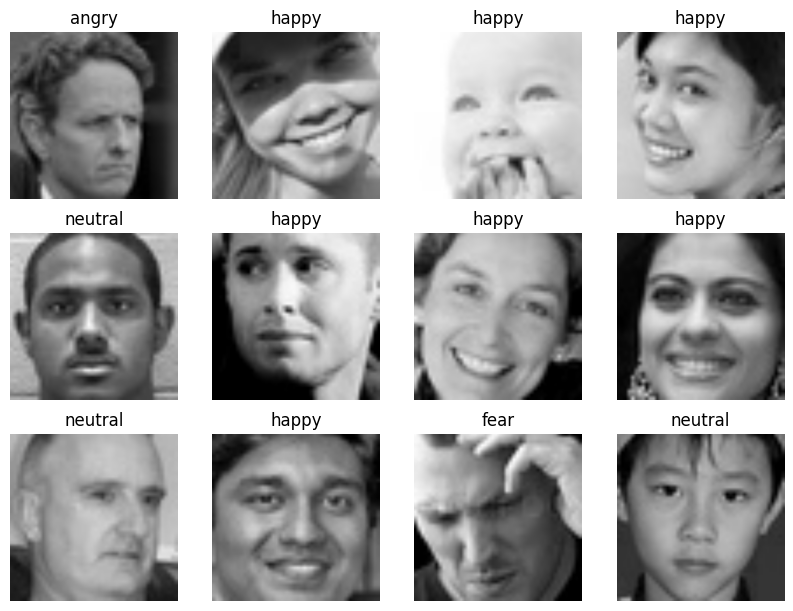

In [11]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [12]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=7)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [13]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [14]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 718

Length of Validation Dataset is 89

Length of Testing Dataset is 91


In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
])

In [31]:
import warnings
warnings.filterwarnings("ignore")

n_classes = 7
input_shape = (32, 48, 48, 1)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(48, 48, 1))


In [32]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 128)       

In [33]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [34]:
warnings.filterwarnings("ignore")
history = model.fit(
train_ds,
epochs=20,
batch_size=32,
verbose=1,
validation_data=val_ds)

Epoch 1/20


ValueError: in user code:

    File "c:\Users\ADMIN\anaconda3\envs\ai\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ADMIN\anaconda3\envs\ai\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ADMIN\anaconda3\envs\ai\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ADMIN\anaconda3\envs\ai\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\ADMIN\anaconda3\envs\ai\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ADMIN\anaconda3\envs\ai\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 48, 48, 1), found shape=(None, 256, 256, 3)
